
Nodule 1 Characteristics:
 - Malignancy: 5 Highly Suspicious
 - Margin: 1 Poorly Defined
 - Spiculation: 1 No Spiculation


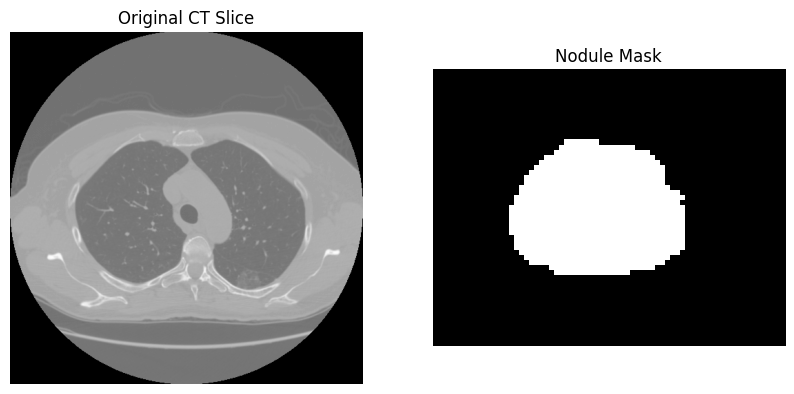

 - Malignancy: 4 Moderately Suspicious
 - Margin: 2 Near Poorly Defined
 - Spiculation: 1 No Spiculation


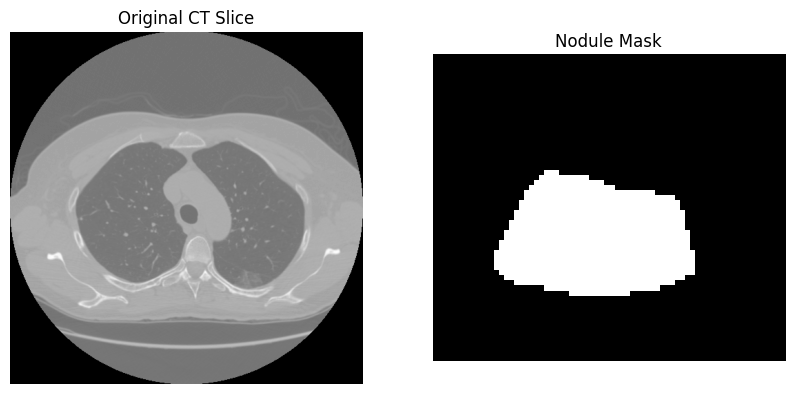

In [10]:
import os
import numpy as np
import pydicom
import pylidc as pl
import matplotlib.pyplot as plt

def stack_dicom_files(directory):
    # Get a list of all DICOM files in the directory
    dicom_files = [os.path.join(directory, filename) for filename in os.listdir(directory) if filename.endswith('.dcm')]
    dicom_files.sort(key=lambda x: pydicom.dcmread(x).ImagePositionPatient[2])

    first_dicom = pydicom.dcmread(dicom_files[0])
    shape = (first_dicom.Rows, first_dicom.Columns, len(dicom_files))
    ct_volume = np.empty(shape, dtype=first_dicom.pixel_array.dtype)

    for i, dicom_file in enumerate(dicom_files):
        dicom_data = pydicom.dcmread(dicom_file)
        ct_volume[:, :, i] = dicom_data.pixel_array

    return ct_volume

# Load DICOM volume
subject_directory = r"C:\Reza Gonabadi\Polimi\Master Thesis\LIDC-IDRI_Simplified\LIDC-IDRI-0002"
ct_volume = stack_dicom_files(subject_directory)

# Query annotations for LIDC-IDRI-0001
scans = pl.query(pl.Scan).filter(pl.Scan.patient_id == "LIDC-IDRI-0002").all()

if len(scans) > 0:
    scan = scans[0]
    nodules = scan.cluster_annotations()

    for i, nodule in enumerate(nodules):
        print(f"\nNodule {i+1} Characteristics:")
        for annotation in nodule:
            print(" - Malignancy:", annotation.malignancy, annotation.Malignancy)
            print(" - Margin:", annotation.margin, annotation.Margin)
            print(" - Spiculation:", annotation.spiculation, annotation.Spiculation)

            # Bounding box and mask for the annotation
            bbox = annotation.bbox(pad=10)
            mask = annotation.boolean_mask(pad=10)
            
            # Displaying a single slice of the nodule with its mask
            slice_idx = (bbox[2].start + bbox[2].stop) // 2  # Choose a middle slice in the z-axis
            plt.figure(figsize=(10, 5))
            plt.subplot(1, 2, 1)
            plt.imshow(ct_volume[:, :, slice_idx], cmap='gray')
            plt.title("Original CT Slice")
            plt.axis('off')
            
            plt.subplot(1, 2, 2)
            plt.imshow(mask[:, :, slice_idx - bbox[2].start], cmap='gray')
            plt.title("Nodule Mask")
            plt.axis('off')
            
            plt.show()

            # Optionally, visualize in 3D
            # annotation.visualize_in_3d()  # Uncomment to visualize in 3D

else:
    print("No scans found for LIDC-IDRI-0001")


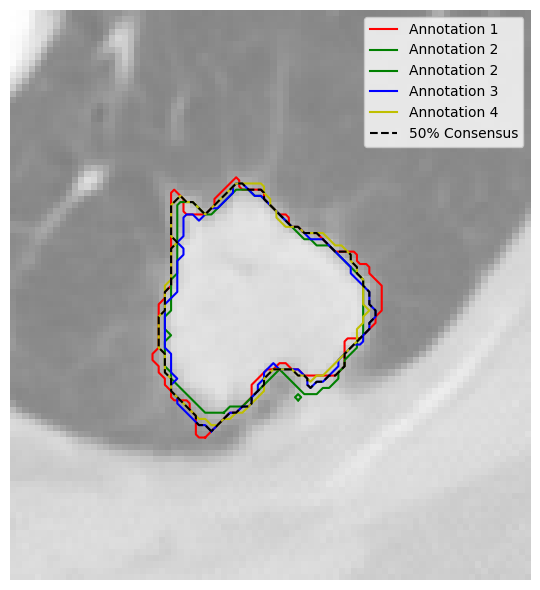

In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
from skimage.measure import find_contours
import pylidc as pl
from pylidc.utils import consensus

# Function to stack DICOM files into a volume (for context, but using pylidc to load scan below)
def stack_dicom_files(directory):
    dicom_files = [os.path.join(directory, filename) for filename in os.listdir(directory) if filename.endswith('.dcm')]
    dicom_files.sort(key=lambda x: pydicom.dcmread(x).ImagePositionPatient[2])
    first_dicom = pydicom.dcmread(dicom_files[0])
    shape = (first_dicom.Rows, first_dicom.Columns, len(dicom_files))
    ct_volume = np.empty(shape, dtype=first_dicom.pixel_array.dtype)
    for i, dicom_file in enumerate(dicom_files):
        dicom_data = pydicom.dcmread(dicom_file)
        ct_volume[:, :, i] = dicom_data.pixel_array
    return ct_volume

# Load DICOM volume
subject_directory = r"C:\Reza Gonabadi\Polimi\Master Thesis\LIDC-IDRI_Simplified\LIDC-IDRI-0001"
ct_volume = stack_dicom_files(subject_directory)

# Query scan and annotations
scan = pl.query(pl.Scan).filter(pl.Scan.patient_id == "LIDC-IDRI-0001").first()
nodules = scan.cluster_annotations()

# Select a nodule (e.g., the first one) and retrieve annotations
if nodules:
    anns = nodules[0]  # Selecting the first nodule
    
    # Calculate 50% consensus mask
    cmask, cbbox, masks = consensus(anns, clevel=0.5, pad=[(20,20), (20,20), (0,0)])
    
    # Central slice in the consensus bounding box
    central_slice_idx = int(0.5 * (cbbox[2].stop - cbbox[2].start))
    
    # Set up the plot
    fig, ax = plt.subplots(1, 1, figsize=(6, 6))
    ax.imshow(ct_volume[cbbox][:, :, central_slice_idx], cmap='gray', alpha=0.5)
    
    # Plot individual annotation contours
    colors = ['r', 'g', 'b', 'y']  # For up to 4 annotations
    for j, mask in enumerate(masks):
        for contour in find_contours(mask[:, :, central_slice_idx].astype(float), 0.5):
            ax.plot(contour[:, 1], contour[:, 0], colors[j % len(colors)], label=f"Annotation {j+1}")
    
    # Plot the 50% consensus contour
    for contour in find_contours(cmask[:, :, central_slice_idx].astype(float), 0.5):
        ax.plot(contour[:, 1], contour[:, 0], '--k', label='50% Consensus')
    
    ax.axis('off')
    ax.legend()
    plt.tight_layout()
    plt.show()
else:
    print("No nodules found for LIDC-IDRI-0001")


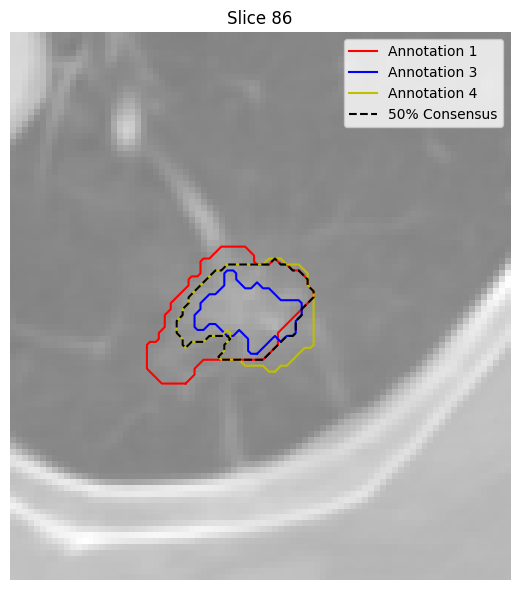

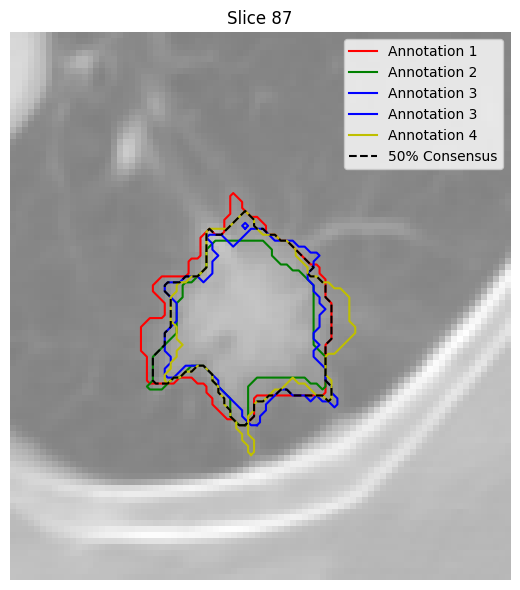

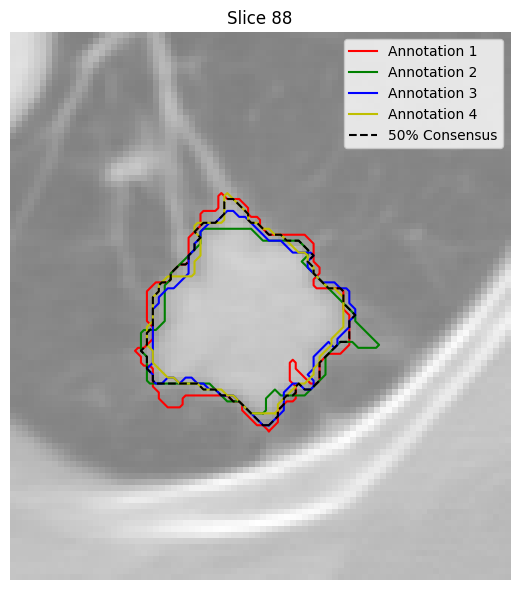

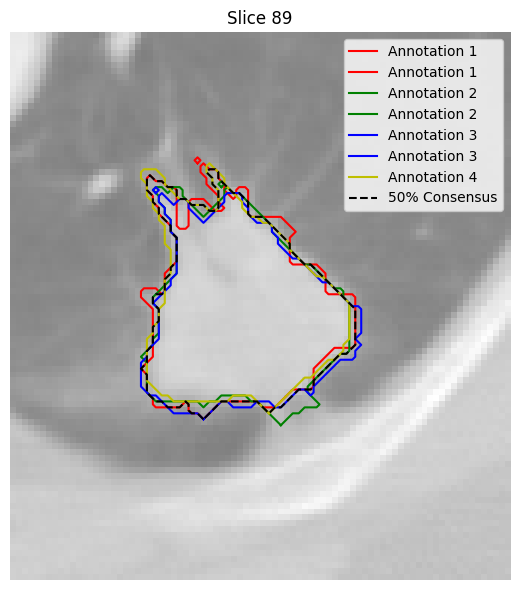

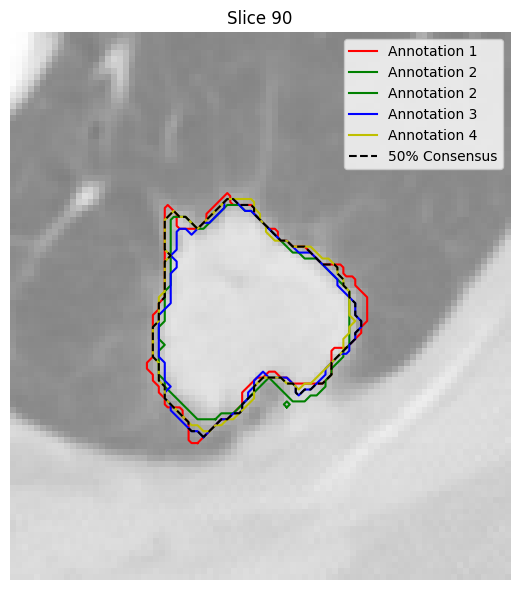

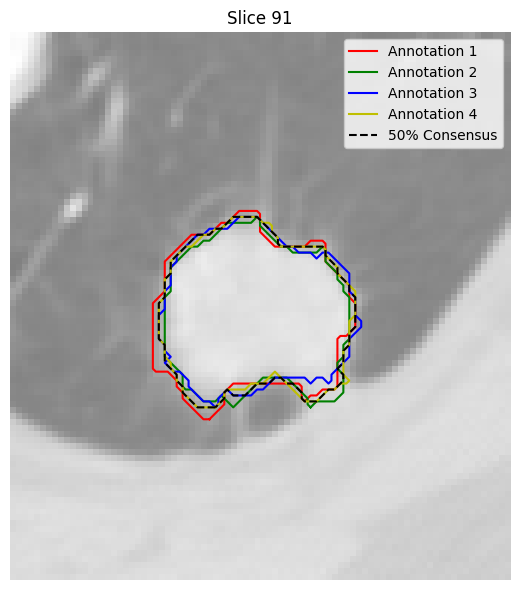

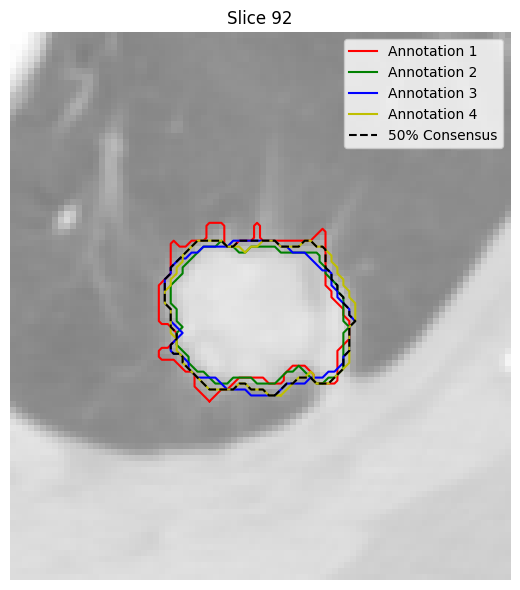

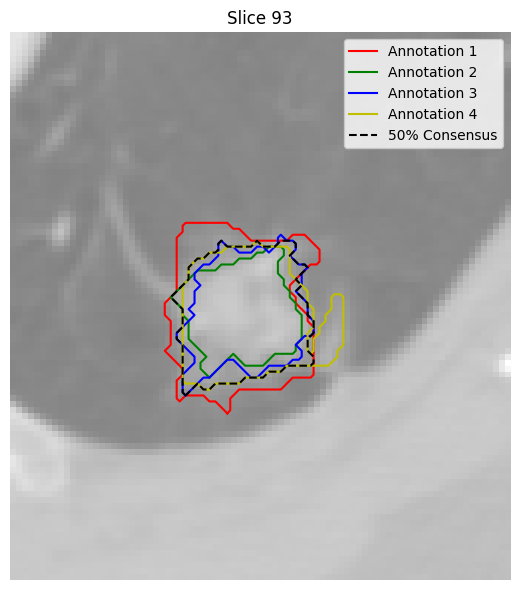

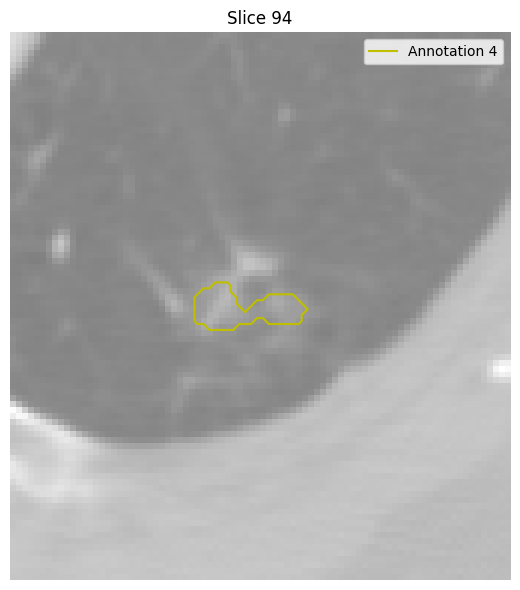

In [4]:
import os
import numpy as np
import matplotlib.pyplot as plt
from skimage.measure import find_contours
import pylidc as pl
from pylidc.utils import consensus

# Function to stack DICOM files into a volume (context, but we're using pylidc for scan below)
def stack_dicom_files(directory):
    dicom_files = [os.path.join(directory, filename) for filename in os.listdir(directory) if filename.endswith('.dcm')]
    dicom_files.sort(key=lambda x: pydicom.dcmread(x).ImagePositionPatient[2])
    first_dicom = pydicom.dcmread(dicom_files[0])
    shape = (first_dicom.Rows, first_dicom.Columns, len(dicom_files))
    ct_volume = np.empty(shape, dtype=first_dicom.pixel_array.dtype)
    for i, dicom_file in enumerate(dicom_files):
        dicom_data = pydicom.dcmread(dicom_file)
        ct_volume[:, :, i] = dicom_data.pixel_array
    return ct_volume

# Load DICOM volume
subject_directory = r"C:\Reza Gonabadi\Polimi\Master Thesis\LIDC-IDRI_Simplified\LIDC-IDRI-0001"
ct_volume = stack_dicom_files(subject_directory)

# Query scan and annotations
scan = pl.query(pl.Scan).filter(pl.Scan.patient_id == "LIDC-IDRI-0001").first()
nodules = scan.cluster_annotations()

# Select a nodule (e.g., the first one) and retrieve annotations
if nodules:
    anns = nodules[0]  # Selecting the first nodule

    # Calculate 50% consensus mask and bounding box
    cmask, cbbox, masks = consensus(anns, clevel=0.5, pad=[(20,20), (20,20), (0,0)])

    # Loop through each slice within the consensus bounding box range
    for slice_idx in range(cbbox[2].start, cbbox[2].stop):
        fig, ax = plt.subplots(1, 1, figsize=(6, 6))
        
        # Display the CT slice for the current index within the bounding box
        ax.imshow(ct_volume[cbbox][:, :, slice_idx - cbbox[2].start], cmap='gray', alpha=0.5)
        
        # Plot individual annotation contours on this slice
        colors = ['r', 'g', 'b', 'y']  # For up to 4 annotations
        for j, mask in enumerate(masks):
            for contour in find_contours(mask[:, :, slice_idx - cbbox[2].start].astype(float), 0.5):
                ax.plot(contour[:, 1], contour[:, 0], colors[j % len(colors)], label=f"Annotation {j+1}")
        
        # Plot the 50% consensus contour
        for contour in find_contours(cmask[:, :, slice_idx - cbbox[2].start].astype(float), 0.5):
            ax.plot(contour[:, 1], contour[:, 0], '--k', label='50% Consensus')
        
        ax.axis('off')
        ax.legend()
        plt.title(f"Slice {slice_idx}")
        plt.tight_layout()
        plt.show()

else:
    print("No nodules found for LIDC-IDRI-0001")


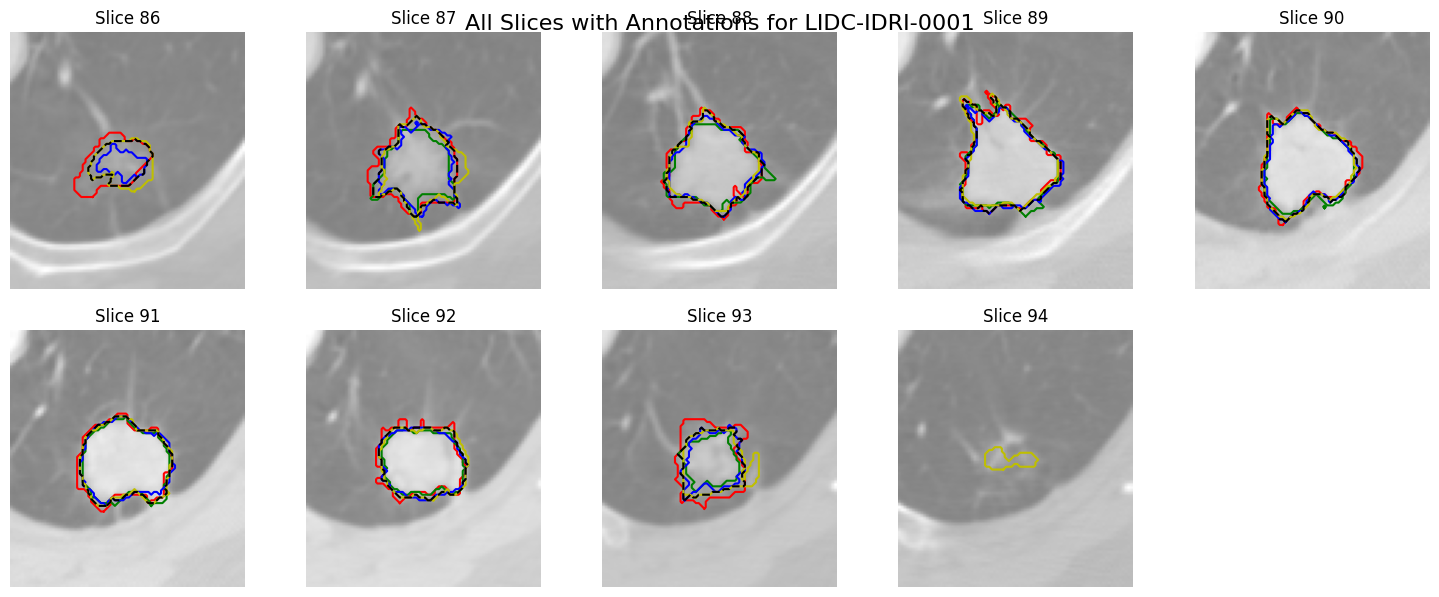

In [5]:
import os
import numpy as np
import matplotlib.pyplot as plt
from skimage.measure import find_contours
import pylidc as pl
from pylidc.utils import consensus

# Function to stack DICOM files into a volume (context, but we're using pylidc for scan below)
def stack_dicom_files(directory):
    dicom_files = [os.path.join(directory, filename) for filename in os.listdir(directory) if filename.endswith('.dcm')]
    dicom_files.sort(key=lambda x: pydicom.dcmread(x).ImagePositionPatient[2])
    first_dicom = pydicom.dcmread(dicom_files[0])
    shape = (first_dicom.Rows, first_dicom.Columns, len(dicom_files))
    ct_volume = np.empty(shape, dtype=first_dicom.pixel_array.dtype)
    for i, dicom_file in enumerate(dicom_files):
        dicom_data = pydicom.dcmread(dicom_file)
        ct_volume[:, :, i] = dicom_data.pixel_array
    return ct_volume

# Load DICOM volume
subject_directory = r"C:\Reza Gonabadi\Polimi\Master Thesis\LIDC-IDRI_Simplified\LIDC-IDRI-0001"
ct_volume = stack_dicom_files(subject_directory)

# Query scan and annotations
scan = pl.query(pl.Scan).filter(pl.Scan.patient_id == "LIDC-IDRI-0001").first()
nodules = scan.cluster_annotations()

# Select a nodule (e.g., the first one) and retrieve annotations
if nodules:
    anns = nodules[0]  # Selecting the first nodule

    # Calculate 50% consensus mask and bounding box
    cmask, cbbox, masks = consensus(anns, clevel=0.5, pad=[(20,20), (20,20), (0,0)])
    
    # Determine the number of slices in the bounding box
    num_slices = cbbox[2].stop - cbbox[2].start
    
    # Set up subplot grid
    cols = 5  # Number of columns for subplots
    rows = int(np.ceil(num_slices / cols))  # Number of rows based on slice count
    fig, axes = plt.subplots(rows, cols, figsize=(15, 3 * rows))
    fig.suptitle(f"All Slices with Annotations for LIDC-IDRI-0001", fontsize=16)
    
    # Loop through each slice within the consensus bounding box range
    for i, slice_idx in enumerate(range(cbbox[2].start, cbbox[2].stop)):
        row, col = divmod(i, cols)  # Calculate subplot position
        ax = axes[row, col]
        
        # Display the CT slice for the current index within the bounding box
        ax.imshow(ct_volume[cbbox][:, :, slice_idx - cbbox[2].start], cmap='gray', alpha=0.5)
        
        # Plot individual annotation contours on this slice
        colors = ['r', 'g', 'b', 'y']  # For up to 4 annotations
        for j, mask in enumerate(masks):
            for contour in find_contours(mask[:, :, slice_idx - cbbox[2].start].astype(float), 0.5):
                ax.plot(contour[:, 1], contour[:, 0], colors[j % len(colors)], label=f"Annotation {j+1}")
        
        # Plot the 50% consensus contour
        for contour in find_contours(cmask[:, :, slice_idx - cbbox[2].start].astype(float), 0.5):
            ax.plot(contour[:, 1], contour[:, 0], '--k', label='50% Consensus')
        
        ax.axis('off')
        ax.set_title(f"Slice {slice_idx}")

    # Hide any unused subplots
    for j in range(i + 1, rows * cols):
        fig.delaxes(axes.flatten()[j])
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.95)  # Adjust layout to fit title
    plt.show()

else:
    print("No nodules found for LIDC-IDRI-0001")


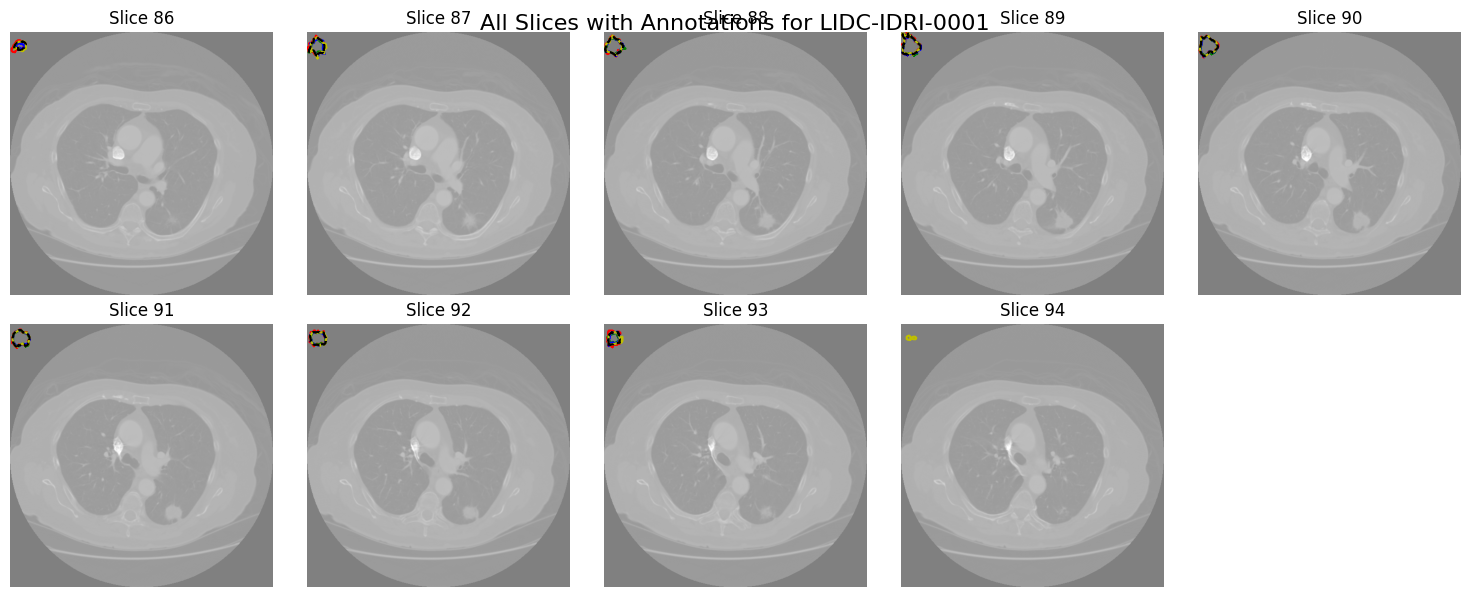

In [8]:
import os
import numpy as np
import matplotlib.pyplot as plt
from skimage.measure import find_contours
import pylidc as pl
from pylidc.utils import consensus

# Function to stack DICOM files into a volume (for the full volume)
def stack_dicom_files(directory):
    dicom_files = [os.path.join(directory, filename) for filename in os.listdir(directory) if filename.endswith('.dcm')]
    dicom_files.sort(key=lambda x: pydicom.dcmread(x).ImagePositionPatient[2])
    first_dicom = pydicom.dcmread(dicom_files[0])
    shape = (first_dicom.Rows, first_dicom.Columns, len(dicom_files))
    ct_volume = np.empty(shape, dtype=first_dicom.pixel_array.dtype)
    for i, dicom_file in enumerate(dicom_files):
        dicom_data = pydicom.dcmread(dicom_file)
        ct_volume[:, :, i] = dicom_data.pixel_array
    return ct_volume

# Load the full DICOM volume
subject_directory = r"C:\Reza Gonabadi\Polimi\Master Thesis\LIDC-IDRI_Simplified\LIDC-IDRI-0001"
ct_volume = stack_dicom_files(subject_directory)

# Query scan and annotations
scan = pl.query(pl.Scan).filter(pl.Scan.patient_id == "LIDC-IDRI-0001").first()
nodules = scan.cluster_annotations()

# Select a nodule (e.g., the first one) and retrieve annotations
if nodules:
    anns = nodules[0]  # Selecting the first nodule

    # Calculate 50% consensus mask and bounding box
    cmask, cbbox, masks = consensus(anns, clevel=0.5, pad=[(0,0), (0,0), (0,0)])  # No padding to avoid zoom
    
    # Determine the number of slices in the bounding box range
    num_slices = cbbox[2].stop - cbbox[2].start
    
    # Set up subplot grid
    cols = 5  # Number of columns for subplots
    rows = int(np.ceil(num_slices / cols))  # Number of rows based on slice count
    fig, axes = plt.subplots(rows, cols, figsize=(15, 3 * rows))
    fig.suptitle(f"All Slices with Annotations for LIDC-IDRI-0001", fontsize=16)
    
    # Loop through each slice within the bounding box range in the full volume
    for i, slice_idx in enumerate(range(cbbox[2].start, cbbox[2].stop)):
        row, col = divmod(i, cols)  # Calculate subplot position
        ax = axes[row, col]
        
        # Display the full CT slice for the actual volume slice index
        ax.imshow(ct_volume[:, :, slice_idx], cmap='gray', alpha=0.5)
        
        # Plot individual annotation contours on this slice
        colors = ['r', 'g', 'b', 'y']  # For up to 4 annotations
        for j, mask in enumerate(masks):
            for contour in find_contours(mask[:, :, slice_idx - cbbox[2].start].astype(float), 0.5):
                ax.plot(contour[:, 1], contour[:, 0], colors[j % len(colors)], label=f"Annotation {j+1}")
        
        # Plot the 50% consensus contour
        for contour in find_contours(cmask[:, :, slice_idx - cbbox[2].start].astype(float), 0.5):
            ax.plot(contour[:, 1], contour[:, 0], '--k', label='50% Consensus')
        
        ax.axis('off')
        ax.set_title(f"Slice {slice_idx}")

    # Hide any unused subplots
    for j in range(i + 1, rows * cols):
        fig.delaxes(axes.flatten()[j])
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.95)  # Adjust layout to fit title
    plt.show()

else:
    print("No nodules found for LIDC-IDRI-0001")



Nodule 1 Characteristics:
 - Malignancy: 5 Highly Suspicious
 - Margin: 3 Medium Margin
 - Spiculation: 4 Near Marked Spiculation


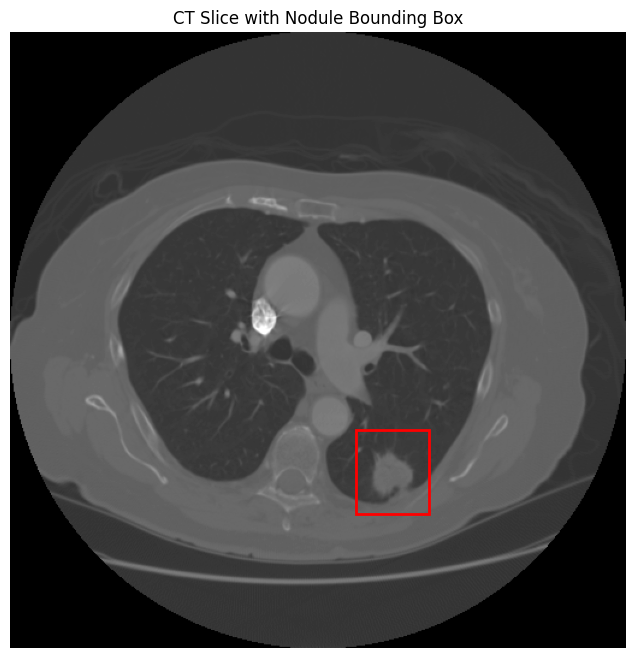

 - Malignancy: 5 Highly Suspicious
 - Margin: 4 Near Sharp
 - Spiculation: 5 Marked Spiculation


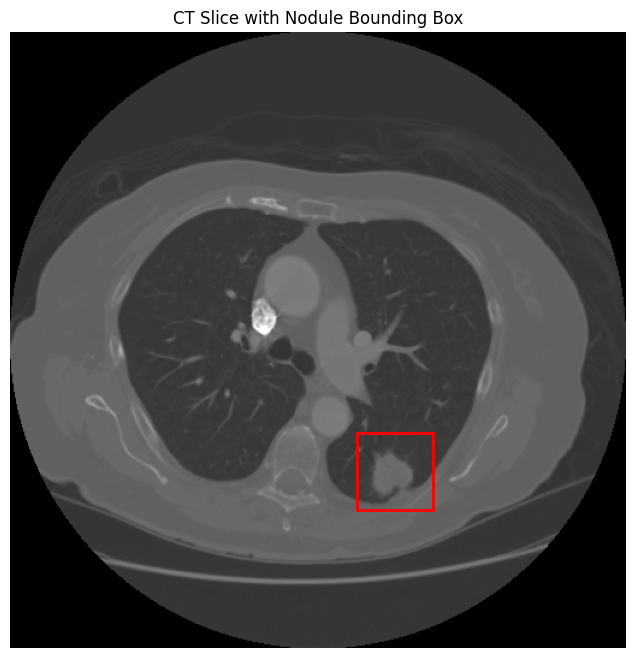

 - Malignancy: 5 Highly Suspicious
 - Margin: 2 Near Poorly Defined
 - Spiculation: 3 Medium Spiculation


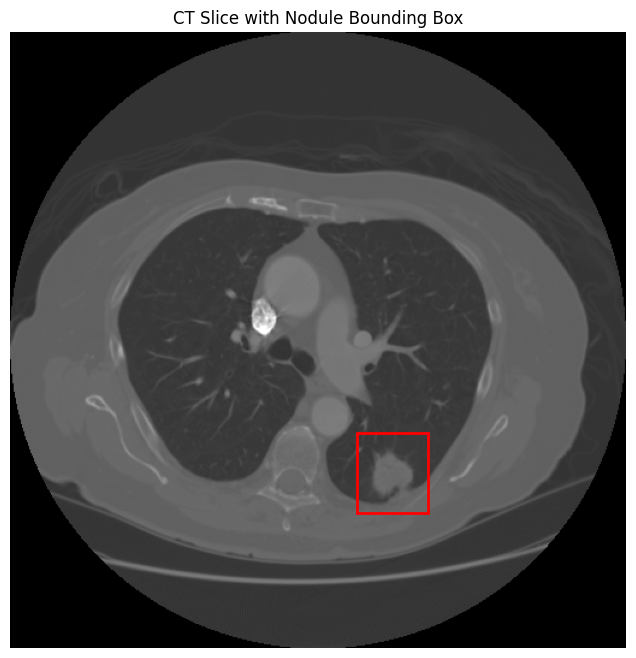

 - Malignancy: 4 Moderately Suspicious
 - Margin: 4 Near Sharp
 - Spiculation: 5 Marked Spiculation


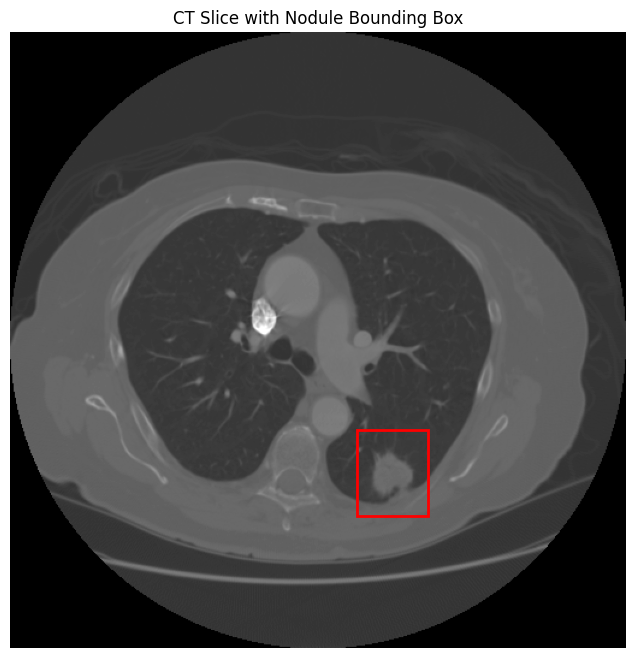

In [13]:
import os
import numpy as np
import pydicom
import pylidc as pl
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

def stack_dicom_files(directory):
    # Get a list of all DICOM files in the directory
    dicom_files = [os.path.join(directory, filename) for filename in os.listdir(directory) if filename.endswith('.dcm')]
    dicom_files.sort(key=lambda x: pydicom.dcmread(x).ImagePositionPatient[2])

    first_dicom = pydicom.dcmread(dicom_files[0])
    shape = (first_dicom.Rows, first_dicom.Columns, len(dicom_files))
    ct_volume = np.empty(shape, dtype=first_dicom.pixel_array.dtype)

    for i, dicom_file in enumerate(dicom_files):
        dicom_data = pydicom.dcmread(dicom_file)
        ct_volume[:, :, i] = dicom_data.pixel_array

    return ct_volume

# Load DICOM volume
subject_directory = r"C:\Reza Gonabadi\Polimi\Master Thesis\LIDC-IDRI_Simplified\LIDC-IDRI-0001"
ct_volume = stack_dicom_files(subject_directory)

# Query annotations for LIDC-IDRI-0002
scans = pl.query(pl.Scan).filter(pl.Scan.patient_id == "LIDC-IDRI-0001").all()

if len(scans) > 0:
    scan = scans[0]
    nodules = scan.cluster_annotations()

    for i, nodule in enumerate(nodules):
        print(f"\nNodule {i+1} Characteristics:")
        for annotation in nodule:
            print(" - Malignancy:", annotation.malignancy, annotation.Malignancy)
            print(" - Margin:", annotation.margin, annotation.Margin)
            print(" - Spiculation:", annotation.spiculation, annotation.Spiculation)

            # Bounding box and mask for the annotation
            bbox = annotation.bbox(pad=10)  # Bounding box with padding

            # Choose a middle slice in the z-axis for visualization
            slice_idx = (bbox[2].start + bbox[2].stop) // 2
            
            # Plot the CT slice with bounding box
            plt.figure(figsize=(8, 8))
            plt.imshow(ct_volume[:, :, slice_idx], cmap='gray')
            plt.title("CT Slice with Nodule Bounding Box")
            plt.axis('off')
            
            # Calculate bounding box dimensions
            x_start, x_end = bbox[1].start, bbox[1].stop
            y_start, y_end = bbox[0].start, bbox[0].stop
            width = x_end - x_start
            height = y_end - y_start

            # Draw the bounding box
            rect = Rectangle((x_start, y_start), width, height, linewidth=2, edgecolor='red', facecolor='none')
            plt.gca().add_patch(rect)
            
            plt.show()

else:
    print("No scans found for LIDC-IDRI-0002")
